# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

### Загрузка и первичный анализ данных

In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [207]:
data = pd.read_csv('coursera.csv', sep=",")

In [208]:
data.shape

(988, 8)

In [209]:
data.dtypes

url                          object
price                        object
course_by                    object
title                        object
skills                       object
ratings                     float64
reviews                      object
level, type and duration     object
dtype: object

In [210]:
data.isnull().sum()

url                           0
price                        32
course_by                     0
title                         0
skills                      182
ratings                      42
reviews                      42
level, type and duration      0
dtype: int64

In [211]:
data.head()

,url,price,course_by,title,skills,ratings,reviews,"level, type and duration"
0,https://www.coursera.org/learn/the-science-of-...,Free,Yale University,The Science of Well-Being,"Personal Development, Business Psychology, Ent...",4.9,(35.5k reviews),Mixed · Course · 1-3 Months
1,https://www.coursera.org/learn/indigenous-canada,Free,University of Alberta,Indigenous Canada,"Leadership and Management, Business Psychology...",4.8,(20.8k reviews),Mixed · Course · 1-3 Months
2,https://www.coursera.org/learn/financial-marke...,Free,Yale University,Financial Markets,"Finance, Banking, Investment Management, Risk ...",4.8,(24.4k reviews),Beginner · Course · 1-3 Months
3,https://www.coursera.org/learn/the-science-of-...,Free,Yale University,The Science of Well-Being for Teens,NaN,4.8,(29 reviews),Beginner · Course · 1-3 Months
4,https://www.coursera.org/learn/introduction-ps...,Free,Yale University,Introduction to Psychology,"Business Psychology, Emotional Intelligence, W...",4.9,(25.5k reviews),Beginner · Course · 1-3 Months


In [212]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 988


## Обработка пропусков в данных
### Для числовых данных

In [213]:
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка ratings. Тип данных float64. Количество пустых значений 42, 4.25%.


In [214]:
data_num = data[num_cols]
data_num

,ratings
0,4.9
1,4.8
2,4.8
3,4.8
4,4.9
...,...
983,4.7
984,4.4
985,NaN
986,NaN


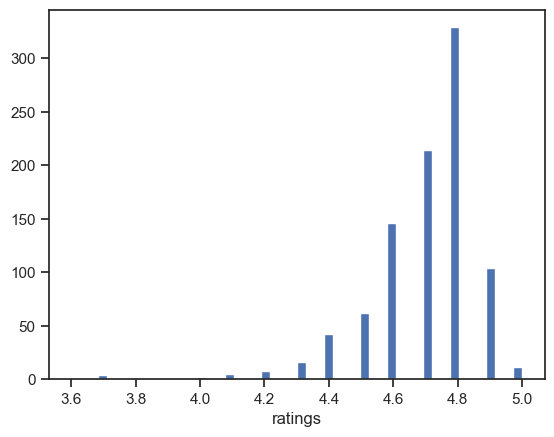

In [215]:
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [216]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [217]:
strategies=['mean', 'median', 'most_frequent']

In [218]:
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [219]:
for strategy in strategies:
    print(test_num_impute_col(data, 'ratings', strategy))

('ratings', 'mean', 42, 4.695560253699789, 4.695560253699789)
('ratings', 'median', 42, 4.7, 4.7)
('ratings', 'most_frequent', 42, 4.8, 4.8)


Поскольку значений составляет менее 5%, то пропуски можно заполнить медианными значениями.

In [220]:
# Заполним пропуски медианными значениями в ratings
imp_num = SimpleImputer(strategy='median')
data_num_imp = imp_num.fit_transform(data[['ratings']])
data['ratings'] = data_num_imp

### Для категориальных данных

In [221]:
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка price. Тип данных object. Количество пустых значений 32, 3.24%.
Колонка skills. Тип данных object. Количество пустых значений 182, 18.42%.
Колонка reviews. Тип данных object. Количество пустых значений 42, 4.25%.


In [222]:
for col in cat_cols:
    print(data[col].describe(), end='\n\n')

count      956
unique       1
top       Free
freq       956
Name: price, dtype: object

count                                                   806
unique                                                  708
top       Business Psychology, Culture, Leadership and M...
freq                                                     21
Name: skills, dtype: object

count                946
unique               506
top       (1.1k reviews)
freq                  29
Name: reviews, dtype: object



Из данных видим:
- `price` - принимает значение `Free` или nan. Заменить nan на `Free` некорректно, так как это может привести к неверным выводам. Поэтому сделаем новый признак `is_free`, который будет принимать значение 1, если `price` = `Free`, и 0 в противном случае. После этого удалим признак `price`.
- `skills` - принимает более 700 уникальных значений. Поэтому просто заменим пропуски на `NA`.
- `reviews` - принимает более 500 уникальных значений. Поэтому просто заменим пропуски на `NA`.

In [223]:
imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
for col in cat_cols:
    data[[col]] = imp.fit_transform(data[[col]])

In [224]:
# удалим колонку price, заменим её на is_free (0 - платный, 1 - бесплатный)
data = data.rename(columns={'price': 'is_free'})

for i in range(data.shape[0]):
    if data.loc[i, 'is_free'] == 'Free':
        data.loc[i, 'is_free'] = 1
    else:
        data.loc[i, 'is_free'] = 0

### Кодирование категориальных признаков

- `reviews` - использует числовые значения внутри строки. Преобразуем их в числовые значения.
- `level, type and duration` - разделим на несколько бинарных признаков. Затем осуществим кодирование `level` и `type` с помощью OneHotEncoder (`level` имеет 3 сравнимых значения и 1 несравнимое - `mixed`)

In [225]:
k_flag = data['reviews'].str.contains('k', regex=False)
data['reviews'] = data['reviews'].str.extract('(\d+\.?\d*)', expand=True).astype(float)
data['reviews'] = data['reviews'] * 1000 * k_flag + data['reviews'] * (~k_flag)

In [226]:
data[['level', 'type', 'duration']] = data['level, type and duration'].str.split(' · ', expand=True)
data.drop(columns=['level, type and duration'], inplace=True)

In [227]:
level_dummies = pd.get_dummies(data['level'], prefix='level')
data = pd.concat([data, level_dummies], axis=1)
data.drop(columns=['level'], inplace=True)

In [228]:
level_dummies = pd.get_dummies(data['type'], prefix='type')
data = pd.concat([data, level_dummies], axis=1)
data.drop(columns=['type'], inplace=True)

In [232]:
data

,url,is_free,course_by,title,skills,ratings,reviews,duration,level_Advanced,level_Beginner,level_Intermediate,level_Mixed,type_Course,type_Guided Project
0,https://www.coursera.org/learn/the-science-of-...,1,Yale University,The Science of Well-Being,"Personal Development, Business Psychology, Ent...",4.9,35500.0,1-3 Months,False,False,False,True,True,False
1,https://www.coursera.org/learn/indigenous-canada,1,University of Alberta,Indigenous Canada,"Leadership and Management, Business Psychology...",4.8,20800.0,1-3 Months,False,False,False,True,True,False
2,https://www.coursera.org/learn/financial-marke...,1,Yale University,Financial Markets,"Finance, Banking, Investment Management, Risk ...",4.8,24400.0,1-3 Months,False,True,False,False,True,False
3,https://www.coursera.org/learn/the-science-of-...,1,Yale University,The Science of Well-Being for Teens,NA,4.8,29.0,1-3 Months,False,True,False,False,True,False
4,https://www.coursera.org/learn/introduction-ps...,1,Yale University,Introduction to Psychology,"Business Psychology, Emotional Intelligence, W...",4.9,25500.0,1-3 Months,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,https://www.coursera.org/learn/structuring-val...,1,The Chinese University of Hong Kong,Structuring Values in Modern China,"Business Psychology, Culture, Leadership and M...",4.7,30.0,1-3 Months,False,False,False,True,True,False
984,https://www.coursera.org/learn/organic-chemistry,1,Xi'an Jiaotong University,有机化学,NA,4.4,79.0,1-3 Months,False,False,False,True,True,False
985,https://www.coursera.org/learn/motivando-equip...,1,Universidad de Palermo,Motivando Equipos de Trabajo,NA,4.7,NaN,1-4 Weeks,False,True,False,False,True,False
986,https://www.coursera.org/learn/empathy-data-risk,1,University of Illinois at Urbana-Champaign,"Empathy, Data, and Risk","Finance, Leadership and Management, Risk Manag...",4.7,NaN,1-3 Months,False,True,False,False,True,False


## Масштабирование данных

Наконец, масштабируем числовые признаки с помощью StandardScaler.

In [229]:
from sklearn.discriminant_analysis import StandardScaler

sc = StandardScaler()
sc_data = sc.fit_transform(data[['ratings', 'reviews']])

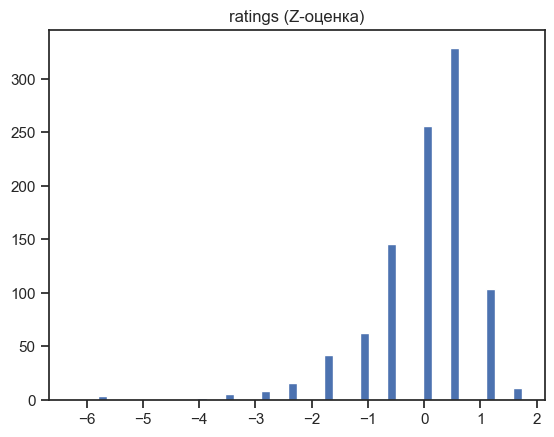

In [230]:
plt.hist(sc_data[:, 0], 50)
plt.title('ratings (Z-оценка)')
plt.show()

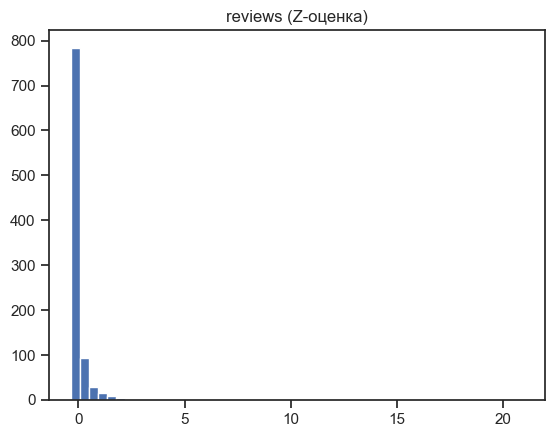

In [231]:
plt.hist(sc_data[:, 1], 50)
plt.title('reviews (Z-оценка)')
plt.show()